In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os

In [2]:
# Function to calculate the mean squared error between two images
def mse(target, ref):
    # Calculate the squared difference sum between the two images and normalize it
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    return err

In [3]:
# Function to prepare degraded images by resizing to introduce quality distortions
def prepare_images(path, factor):
    # Ensure the output directory exists, if not create it
    output_dir = 'images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each file in the directory
    for file in os.listdir(path):
        img = cv2.imread(os.path.join(path, file))
        if img is not None:
            h, w, _ = img.shape
            new_height = int(h / factor)
            new_width = int(w / factor)

            # Downscale the image and then upscale to introduce degradation
            img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
            img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)

            # Save the degraded image
            save_path = os.path.join(output_dir, file)
            cv2.imwrite(save_path, img)
            print('Saving {}'.format(save_path))
        else:
            print(f"Could not read image {file}")

In [4]:
prepare_images('source/', 2) # Degrade the images by a factor of 2

Saving images\book.jpg
Saving images\cheeto.jpg
Saving images\chicks.jpg
Saving images\fox.jpg
Saving images\vegas.jpg
Saving images\zebra.jpg


In [5]:
# Testing the generated images using image quality metrics
for file in os.listdir('images/'):
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))

    # Calculate MSE and print it
    scores = mse(target, ref)
    print('{}\nMSE: {}\n'.format(file, scores))

book.jpg
MSE: 1553.7249709175512

cheeto.jpg
MSE: 665.5158065184237

chicks.jpg
MSE: 145.40329743008314

fox.jpg
MSE: 261.938175787728

vegas.jpg
MSE: 955.1024294661328

zebra.jpg
MSE: 581.9987567623804



In [6]:
# Define the SRCNN model
def model():
    CNN = Sequential()

    # Add model layers: Convolution layers with specified filters and kernel size
    CNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', input_shape=(None, None, 1)))
    CNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same'))
    CNN.add(Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid'))

    # Define the optimizer
    adam = Adam(learning_rate=0.0003)

    # Compile the model with loss and metrics
    CNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return CNN

In [7]:
# Image processing functions to adjust the size and remove the borders
def modcrop(img, scale):
    sz = img.shape[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    return image[border: -border, border: -border]


In [8]:
def predict(image_path):
    
    # Load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # Load the degraded and the original images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # Preprocess the images to be compatible with the model input
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # Convert the image to YCrCb since srcnn is trained on Y channel
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # Normalize the Y channel and prepare it for prediction
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # Predict the high-resolution image from degraded input
    pre = srcnn.predict(Y, batch_size=1)
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # Reconstruct the output image from Y channel
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # Postprocess the images to be compatible with the model output
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # Output the MSEs
    scores = []
    scores.append(mse(degraded, ref))
    scores.append(mse(output, ref))
    
    # Return images and scores
    return ref, degraded, output, scores

d:\MINICONDA\envs\MLclass\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Degraded Image: 
MSE: 614.2138405365455

Reconstructed Image:
MSE: 381.1137677322567



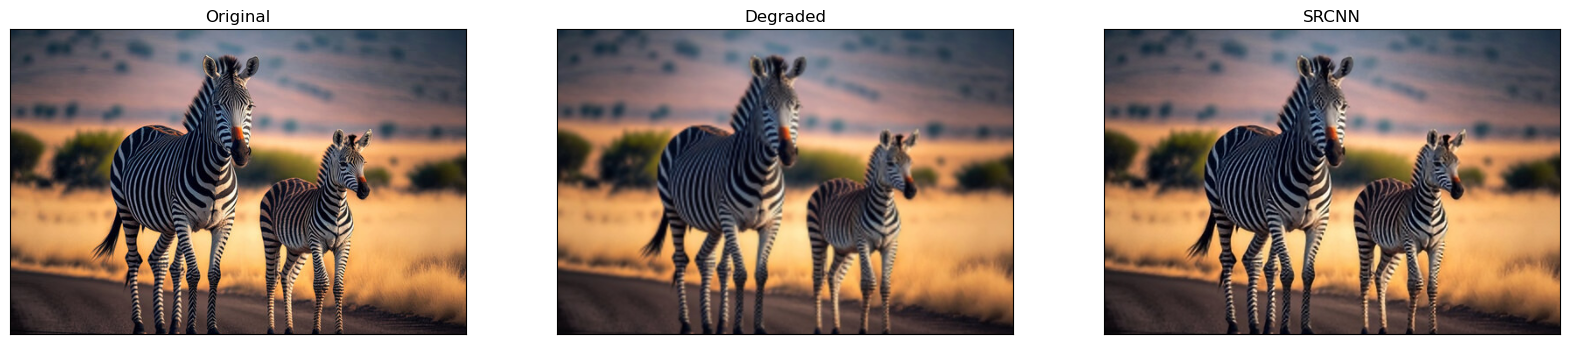

In [9]:
# Run prediction and display results
ref, degraded, output, scores = predict('images/zebra.jpg')
print('Degraded Image: \nMSE: {}\n'.format(scores[0]))
print('Reconstructed Image:\nMSE: {}\n'.format(scores[1]))

# Display images
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')
# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Degraded Image: 
MSE: 263.8451044374389

Reconstructed Image:
MSE: 207.3296462216323



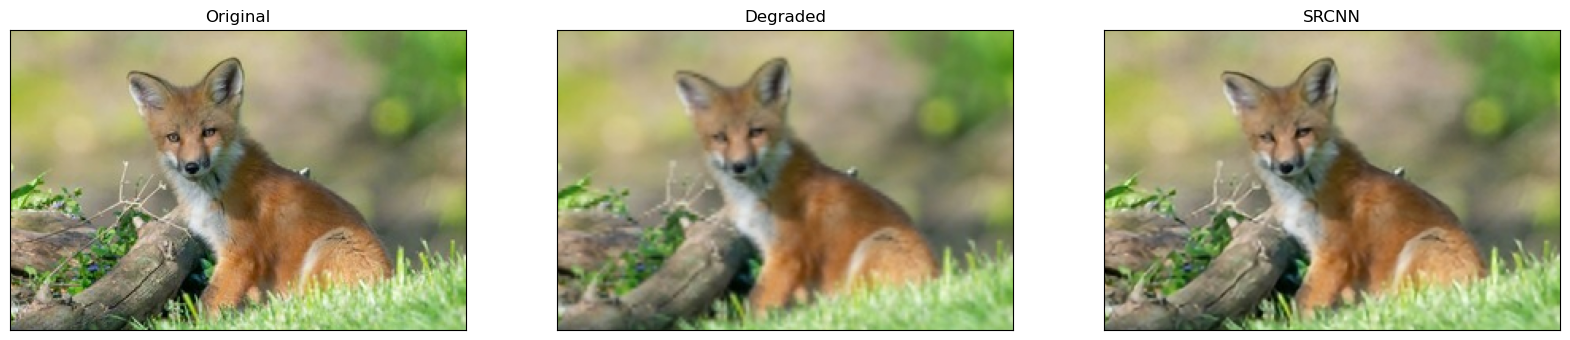

In [10]:
# Run prediction and display results
ref, degraded, output, scores = predict('images/fox.jpg')
print('Degraded Image: \nMSE: {}\n'.format(scores[0]))
print('Reconstructed Image:\nMSE: {}\n'.format(scores[1]))

# Display images
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')
# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
Degraded Image: 
MSE: 149.45726785848984

Reconstructed Image:
MSE: 89.70359684191999



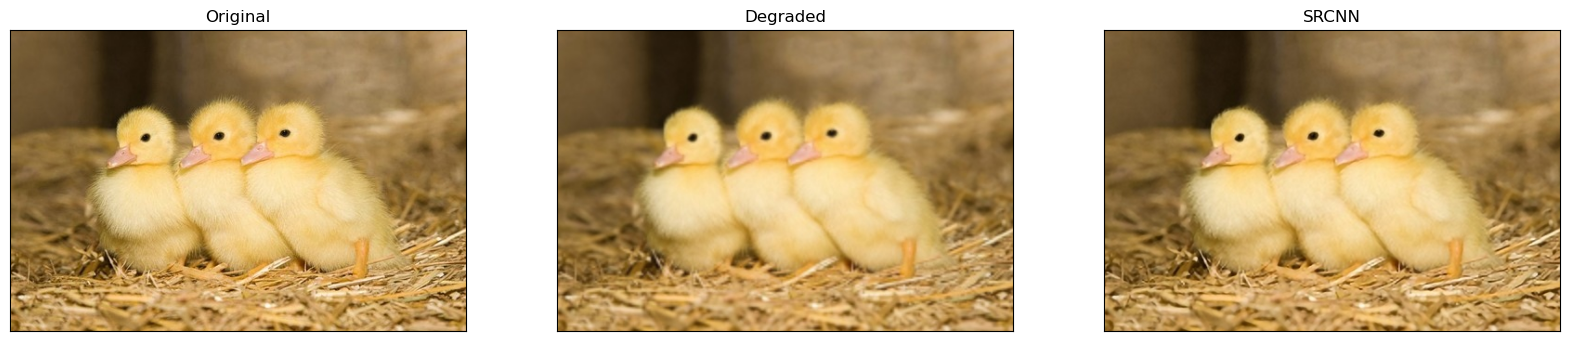

In [11]:
# Run prediction and display results
ref, degraded, output, scores = predict('images/chicks.jpg')
print('Degraded Image: \nMSE: {}\n'.format(scores[0]))
print('Reconstructed Image:\nMSE: {}\n'.format(scores[1]))

# Display images
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')
# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Degraded Image: 
MSE: 695.7954849674383

Reconstructed Image:
MSE: 356.3503937994756



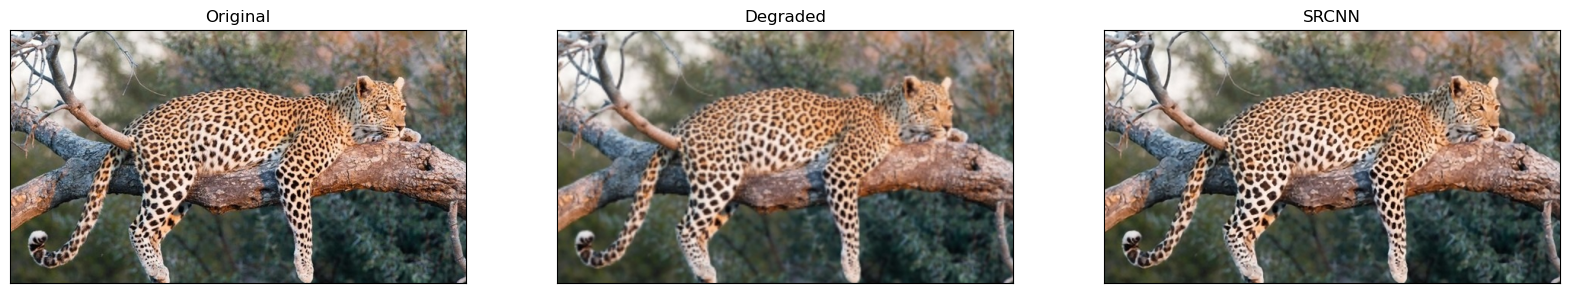

In [12]:
# Run prediction and display results
ref, degraded, output, scores = predict('images/cheeto.jpg')
print('Degraded Image: \nMSE: {}\n'.format(scores[0]))
print('Reconstructed Image:\nMSE: {}\n'.format(scores[1]))

# Display images
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')
# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
Degraded Image: 
MSE: 1637.1497639282343

Reconstructed Image:
MSE: 1218.565443935982



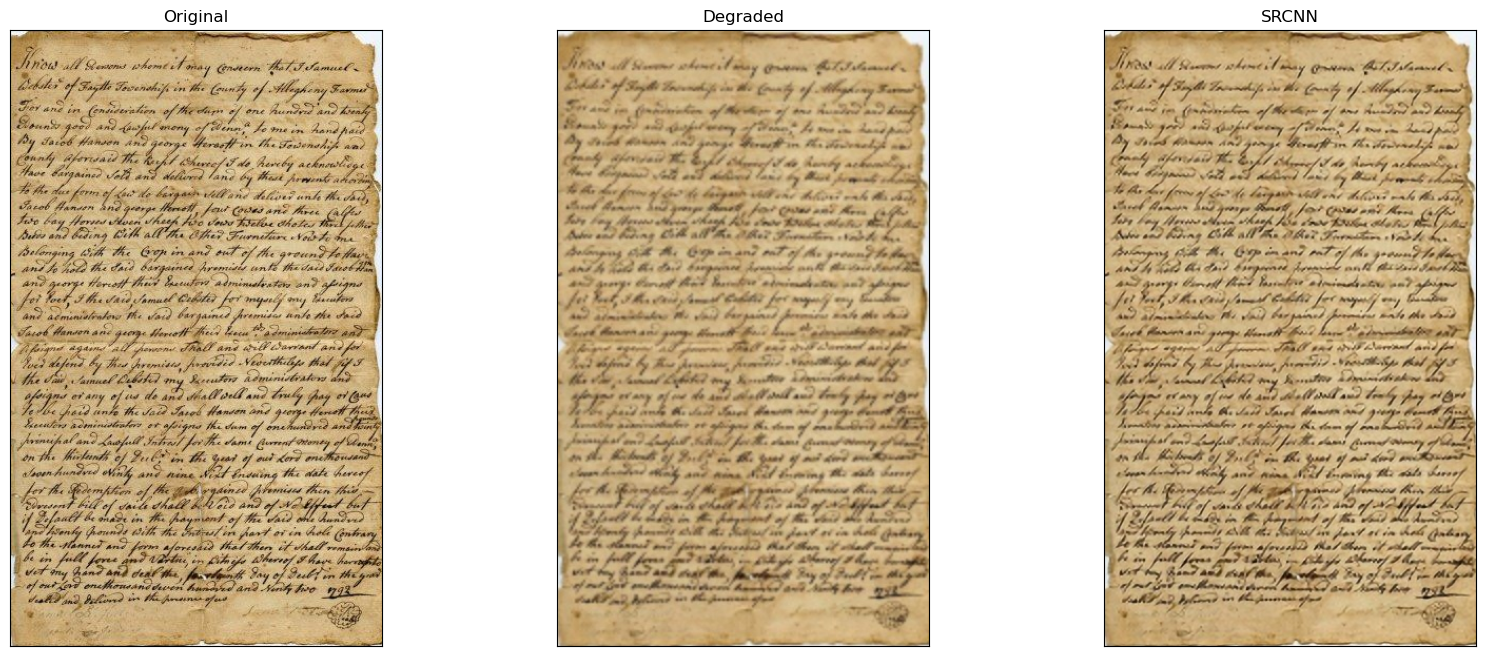

In [13]:
# Run prediction and display results
ref, degraded, output, scores = predict('images/book.jpg')
print('Degraded Image: \nMSE: {}\n'.format(scores[0]))
print('Reconstructed Image:\nMSE: {}\n'.format(scores[1]))

# Display images
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')
# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step
Degraded Image: 
MSE: 955.4746441242924

Reconstructed Image:
MSE: 875.5218894702026



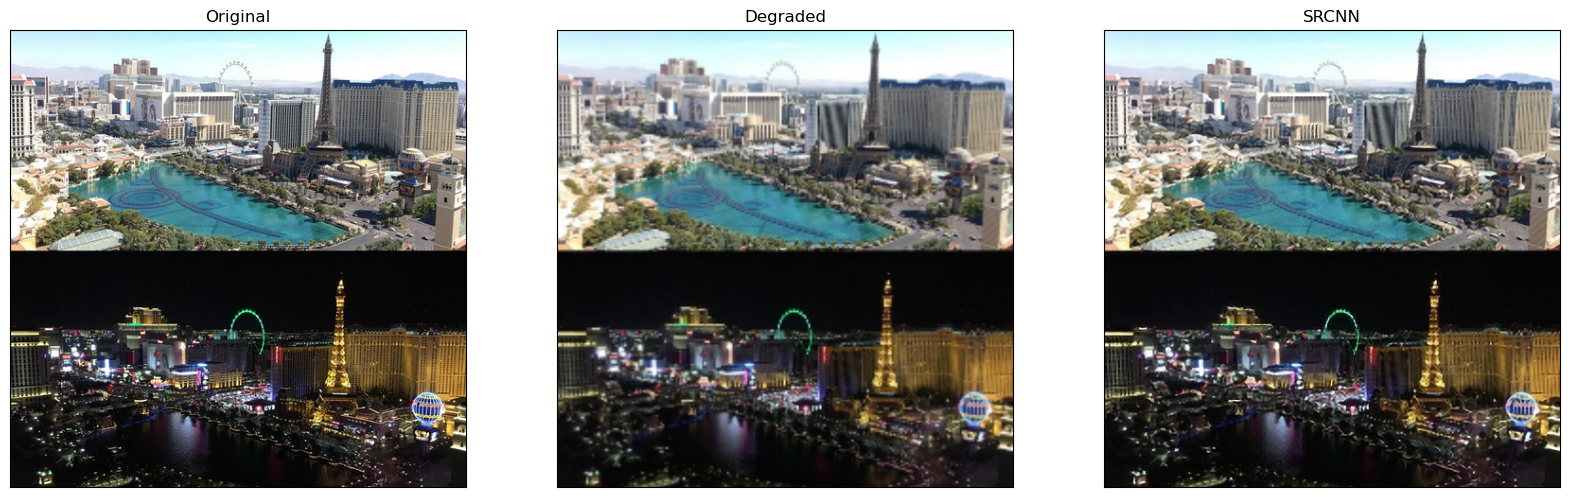

In [14]:
# Run prediction and display results
ref, degraded, output, scores = predict('images/vegas.jpg')
print('Degraded Image: \nMSE: {}\n'.format(scores[0]))
print('Reconstructed Image:\nMSE: {}\n'.format(scores[1]))

# Display images
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')
# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [19]:
# Testing the generated images using image quality metrics
for file in os.listdir('SDresults/'):
    target = cv2.imread('SDresults/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    ref_resized = cv2.resize(ref, (target.shape[1], target.shape[0]))
    
    # Calculate MSE and print it
    scores = mse(target, ref_resized)
    print('{}\nMSE: {}\n'.format(file, scores))

cheeto.jpg
MSE: 938.4376729867636

chicks.jpg
MSE: 168.56470520065665

fox.jpg
MSE: 255.53093020833333

vegas.jpg
MSE: 1148.7603794062175

zebra.jpg
MSE: 467.00966922856844

